# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road**
***
In this Project, you will use the Tools you learned about in the Lesson to identify Lane Lines on the Road.  You can develop your Pipeline on a series of individual Images, and later apply the result to a Video Stream (really just a Series of Images). Check out the Video Clip "raw-lines-example.mp4" (also contained in this Repository) to see what the Output should look like after using the Helper Functions below.

Once you have a Result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to Average and/or Extrapolate the Line Segments you've detected to map out the Full Extent of the Lane Lines.  You can see an Example of the Result you're going for in the Video "P1_example.mp4".  Ultimately, you would like to Draw just One Line for the Left side of the Lane, and One for the Right.

In addition to implementing Code, there is a brief Writeup to complete. The Writeup should be completed in a separate File, which can be either a Markdown File or a pdf Document. There is a [Writeup Template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the Code in the Ipython Notebook and the Writeup Template will cover all of the [Rubric Points](https://review.udacity.com/#!/rubrics/322/view) for this Project.

---
Let's have a look at our First Image called 'test_images/solidWhiteRight.jpg'.  Run the 2 Cells below (Hit Shift-Enter or the "Play" Button above) to Display the Image.

**Note: If, at any point, you encounter Frozen Display Windows or other confounding Issues, you can always Start again with a clean slate by going to the "Kernel" Menu above and selecting "Restart & Clear Output".**

---

**The Tools you have are Color Selection, Region Of Interest Selection, Grayscaling, Gaussian Smoothing, Canny Edge Detection and Hough Tranform Line Detection.  You are also free to explore and try Other Techniques that were not presented in the Lesson.  Your Goal is piece together a Pipeline to Detect the Line Segments in the Image, then Average/Extrapolate them and Draw them onto the Image for Display (as below).  Once you have a working Pipeline, try it out on the Video Stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p>
 <p style="text-align: center;"> Your Output should look something like this (above) after Detecting Line Segments using the Helper Functions below </p>
 </figcaption>
</figure>
 <p></p>
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p>
 <p style="text-align: center;"> Your Goal is to Connect/Average/Extrapolate Line Segments to get Output like this</p>
 </figcaption>
</figure>

**Run the Cell below to Import some Packages.  If you get an `import error` for a Package you've already installed, try changing your Kernel (Select the Kernel Menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the Terminal Prompt.  Also, consult the Forums for more Troubleshooting Tips.**

## Import Packages

In [1]:
#Importing some Useful Packages
import matplotlib.pyplot as plt  # NMK 2018-03-01: mppyplt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This Image is of Type: <class 'numpy.ndarray'> with Dimensions: (540, 960, 3)


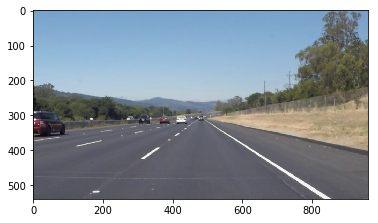

In [2]:
#Reading in an Image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#Printing out some Stats and Plotting
print('This Image is of Type:', type(image), 'with Dimensions:', image.shape)
plt.imshow(image) # If you wanted to show a Single Color Channel Image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV Functions (including beyond those introduced in the Lesson) that might be useful for this Project are:**

`cv2.cvtColor()`    to grayscale or change color  
`cv2.inRange()`     for color selection  
`cv2.fillPoly()`    for regions selection  
`cv2.bitwise_and()` to apply a mask to an image  
`cv2.line()`        to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.imwrite()`     to output images to file

**Check out the OpenCV Documentation to learn about these and discover even more awesome Functionality!**

## Helper Functions

Below are some Helper Functions to help get you started. They should look familiar from the Lesson!

In [3]:
#Importing some Useful Packages
import math

### NMK 2018-03-01: FEATURE SWITCHES:
FEATURE_LANE_LINE_SEGS_AVG              = 1 # Feature: To Average Line Segments and Draw a Single Line per Lane.
FEATURE_LINE_SEGS_MEAN_WEIGHTED         = 1 # Feature: To use Weighted Mean of the Line Segments for the Average Line.
FEATURE_DEV_DEBUG_PRINTS                = 0 # Development Feature: To Enable/Disable Debug Prints.
FEATURE_DEV_LINE_SEGS_FILTERED_ANALYSIS = 0 # Development Feature: To Visualise & Analyse Filtered Line Segments.

def grayscale(img):
    """Applies the Grayscale Transform.
    This will return an Image with only One Color Channel.
    But NOTE: To see the returned Image as Grayscale
    (Assuming your Grayscaled Image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you Read an Image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise Kernel."""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny Transform."""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an Image Mask.
    
    Only keeps the Region of the Image defined by the Polygon formed from `vertices`.
    The Rest of the Image is set to Black.
    """
    #Defining a Blank Mask to Start with
    mask = np.zeros_like(img)
    
    #Defining a 3 Channel or 1 Channel Color to Fill the Mask with depending on the Input Image
    if len(img.shape) > 2:
        channel_count = img.shape[2] # i.e. 3 or 4 Channels depending on your Image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #Filling Pixels inside the Polygon defined by "vertices" (ROI: Region Of Interest)
    #With the Fill Color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #Returning the Image only where Mask Pixels are Non-Zero
    #i.e., Original Image '&' ROI Mask
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4): # NMK 2018-03-01: color = RED.
    """
    NOTE: This is the Function you might want to use as a starting point
    once you want to Average/Extrapolate the Line Segments you detect
    to map out the Full extent of the Lane
    (Going from the result shown in raw-lines-example.mp4 to that shown in P1_example.mp4).
    
    Think about things like
    Separating Line Segments by their Slope ((y2-y1)/(x2-x1))
    to decide which Segments are part of the Left Lane vs. the Right Lane.
    Then, you can Average the Position of each of the Lines
    and Extrapolate to the Top and Bottom of the Lane.
    
    This Function draws `lines` with `color` and `thickness`.
    Lines are drawn on the Image In-place (Mutates the Image).
    If you want to make the Lines Semi-Transparent,
    think about Combining this Function with the weighted_img() Function below
    """
    
    # NMK 2018-03-01: Feature: To Average Line Segments and Draw a Single Line per Lane.
    if (1 == FEATURE_LANE_LINE_SEGS_AVG):
        # Lists to Collect the Right and Left Line Segments' Centers, Slopes and Lenghts.
        line_segs_r_centers = []
        line_segs_r_slopes  = []
        line_segs_l_centers = []
        line_segs_l_slopes  = []
        if (1 == FEATURE_LINE_SEGS_MEAN_WEIGHTED):
            line_segs_r_lengths = []
            line_segs_l_lengths = []
        if (1 == FEATURE_DEV_LINE_SEGS_FILTERED_ANALYSIS):
            line_segs_r_filtered = []
            line_segs_l_filtered = []
        slope_limit_low     = 0.4  # NMK: 2018-03-21: Using a Higher Value especially to tackle "challenge.mp4",
                                   # Wherein a Slant Road Patch & Near Horizontal Shadows are causing Problems!
        slope_limit_high    = 0.9
        line_limit_y        = 0.59 # % Of y Size (Image Height).
                                   # For Line From Image Bottom To line_limit_y.
        
        # Iterate through Each Line Segment, Seggregate the R & L Line Segments and Collect the Centers, Slopes and Lenghts.
        for line in lines:
            for x1,y1,x2,y2 in line:
                # Center and Slope Calc for the Line Segments.
                line_seg_center = [(x1+x2)/2, (y1+y2)/2]
                line_seg_slope  = ((y2-y1)/(x2-x1))
                if (1 == FEATURE_DEV_DEBUG_PRINTS):
                    print("Line Segment:",        line)
                    print("Line Segment Center:", line_seg_center)
                    print("Line Segment Slope:",  line_seg_slope)
                
                # Seggregate the R & L Line Segments based on Slopes.
                if(line_seg_slope >= 0):      # Lane Line Segment in Right.
                    # Avoid Too Horizontal or Too Vertical Line Segments.
                    if not((line_seg_slope < slope_limit_low) or (line_seg_slope > slope_limit_high)):
                        line_segs_r_centers.append(line_seg_center)
                        line_segs_r_slopes.append(line_seg_slope)
                        if (1 == FEATURE_LINE_SEGS_MEAN_WEIGHTED):
                            line_seg_length = np.sqrt(np.power((x2-x1),2) + np.power((y2-y1),2))
                            line_segs_r_lengths.append(line_seg_length)
                        if (1 == FEATURE_DEV_LINE_SEGS_FILTERED_ANALYSIS):
                            line_segs_r_filtered.append(line)
                else: # (line_seg_slope < 0) => Lane Line Segment in Left.
                    # Avoid Too Horizontal or Too Vertical Line Segments.
                    if not((line_seg_slope > -slope_limit_low) or (line_seg_slope < -slope_limit_high)):
                        line_segs_l_centers.append(line_seg_center)
                        line_segs_l_slopes.append(line_seg_slope)
                        if (1 == FEATURE_LINE_SEGS_MEAN_WEIGHTED):
                            line_seg_length = np.sqrt(np.power((x2-x1),2) + np.power((y2-y1),2))
                            line_segs_l_lengths.append(line_seg_length)
                        if (1 == FEATURE_DEV_LINE_SEGS_FILTERED_ANALYSIS):
                            line_segs_l_filtered.append(line)
        if (1 == FEATURE_DEV_DEBUG_PRINTS):
            print("line_segs_r_centers:", line_segs_r_centers)
            print("line_segs_r_slopes:",  line_segs_r_slopes)
            print("line_segs_l_centers:", line_segs_l_centers)
            print("line_segs_l_slopes:",  line_segs_l_slopes)
        
        # Calculate the Average Slope & Average Center of the Line Segments on Each Side [Right, Left].
        line_r_avg_center = []
        line_l_avg_center = []
        if (1 == FEATURE_LINE_SEGS_MEAN_WEIGHTED):
            line_segs_r_total_length = np.sum(line_segs_r_lengths)
            line_segs_l_total_length = np.sum(line_segs_l_lengths)
            
            line_r_avg_slope  = np.divide(np.sum(np.multiply(line_segs_r_slopes, line_segs_r_lengths)), line_segs_r_total_length)
            line_l_avg_slope  = np.divide(np.sum(np.multiply(line_segs_l_slopes, line_segs_l_lengths)), line_segs_l_total_length)
            
            line_segs_r_centers_x = [p[0] for p in line_segs_r_centers]
            line_segs_r_centers_y = [p[1] for p in line_segs_r_centers]
            line_segs_l_centers_x = [p[0] for p in line_segs_l_centers]
            line_segs_l_centers_y = [p[1] for p in line_segs_l_centers]
            
            line_r_avg_center_x = np.divide(np.sum(np.multiply(line_segs_r_centers_x, line_segs_r_lengths),axis=0), line_segs_r_total_length)
            line_r_avg_center_y = np.divide(np.sum(np.multiply(line_segs_r_centers_y, line_segs_r_lengths),axis=0), line_segs_r_total_length)
            line_r_avg_center   = [line_r_avg_center_x, line_r_avg_center_y]
            
            line_l_avg_center_x = np.divide(np.sum(np.multiply(line_segs_l_centers_x, line_segs_l_lengths),axis=0), line_segs_l_total_length)
            line_l_avg_center_y = np.divide(np.sum(np.multiply(line_segs_l_centers_y, line_segs_l_lengths),axis=0), line_segs_l_total_length)
            line_l_avg_center   = [line_l_avg_center_x, line_l_avg_center_y]
        else:
            line_r_avg_slope  = np.divide(np.sum(line_segs_r_slopes), len(line_segs_r_slopes))
            line_l_avg_slope  = np.divide(np.sum(line_segs_l_slopes), len(line_segs_l_slopes))
            line_r_avg_center = np.divide(np.sum(line_segs_r_centers,axis=0), len(line_segs_r_centers))
            line_l_avg_center = np.divide(np.sum(line_segs_l_centers,axis=0), len(line_segs_l_centers))
        if (1 == FEATURE_DEV_DEBUG_PRINTS):
            print("line_r_avg_center:", line_r_avg_center)
            print("line_r_avg_slope:",  line_r_avg_slope)
            print("line_l_avg_center:", line_l_avg_center)
            print("line_l_avg_slope:",  line_l_avg_slope)
        
        ### ERROR HANDLING!!!: #################################################################
        # For some Particular Frame(s) in the Video "challenge.mp4",
        # line_r_avg_center _or_ line_l_avg_center is somehow NOT a Proper Co-ordinate (List),
        # but it Becomes an Object of Type 'numpy.float64' instead of 'list'!!!
        # So, Access of Individual x or y Co-ordinate (For Example, line_l_avg_center[0]) Below
        # Causes Error:
        #    "IndexError: invalid index to scalar variable."
        # So, in These Cases, RETURN WITHOUT DRAWING LINE for the Particular Frame!
        ########################################################################################
        if ((type(line_r_avg_center) == np.float64) or (type(line_l_avg_center) == np.float64)):
            return
        
        # NMK 2018-03-01: Draw the Right Average Line & Left Average Line!
        # y=Mx => (y-y')=M(x-x'), Where (x,y) is the Center & M is the Slope.
        #         => x' = x - ((y-y')/M)
        # For Right Average Line:
        #    Top    Point: Find x1 by Substituting y1 as at a Specified Height of img
        #                                                     -> (line_limit_y * img_shape[0])
        #    Bottom Point: Find x2 by Substituting y2 as at the Bottom of img -> img_shape[0]
        # For Left Average Line:
        #    Bottom Point: Find x1 by Substituting y1 as at the Bottom of img -> img_shape[0]
        #    Top    Point: Find x2 by Substituting y2 as at a Specified Height of img
        #                                                     -> (line_limit_y * img_shape[0])
        # NOTE!:
        #    Convert the Co-ordinates To 'int' so as to pass to cv2.line() Function.
        img_shape = img.shape # img_shape[0] -> No. of Rows,    y Size.
                              # img_shape[1] -> No. of Columns, x Size.
                              # img_shape[2] -> No. of Color Channels.
        if (1 == FEATURE_DEV_DEBUG_PRINTS):
            print("Image Shape:", img_shape)
        line_r_avg_y1 = (line_limit_y * img_shape[0])
        line_r_avg_x1 = (line_r_avg_center[0] - np.divide((line_r_avg_center[1]-line_r_avg_y1), line_r_avg_slope))
        line_r_avg_y2 = (img_shape[0])
        line_r_avg_x2 = (line_r_avg_center[0] - np.divide((line_r_avg_center[1]-line_r_avg_y2), line_r_avg_slope))
        line_l_avg_y1 = (img_shape[0])
        line_l_avg_x1 = (line_l_avg_center[0] - np.divide((line_l_avg_center[1]-line_l_avg_y1), line_l_avg_slope))
        line_l_avg_y2 = (line_limit_y * img_shape[0])
        line_l_avg_x2 = (line_l_avg_center[0] - np.divide((line_l_avg_center[1]-line_l_avg_y2), line_l_avg_slope))
        
        ### ERROR HANDLING!!!: #################################################################
        # For some Particular Frame(s) in the Video "challenge.mp4",
        # some Parameter Above (For Example, line_l_avg_x1) somehow Becomes 'NaN'!!!
        # So, Conversion To 'int' Below
        # Causes Error:
        #    "ValueError: cannot convert float NaN to integer"
        # So, in These Cases, RETURN WITHOUT DRAWING LINE for the Particular Frame!
        ########################################################################################
        if (math.isnan(line_r_avg_y1) or math.isnan(line_r_avg_x1) or
            math.isnan(line_r_avg_y2) or math.isnan(line_r_avg_x2) or
            math.isnan(line_l_avg_y1) or math.isnan(line_l_avg_x1) or
            math.isnan(line_l_avg_y2) or math.isnan(line_l_avg_x2)):
            return
        
        else:
            line_r_avg_y1 = int(line_r_avg_y1)
            line_r_avg_x1 = int(line_r_avg_x1)
            line_r_avg_y2 = int(line_r_avg_y2)
            line_r_avg_x2 = int(line_r_avg_x2)
            line_l_avg_y1 = int(line_l_avg_y1)
            line_l_avg_x1 = int(line_l_avg_x1)
            line_l_avg_y2 = int(line_l_avg_y2)
            line_l_avg_x2 = int(line_l_avg_x2)
        if (1 == FEATURE_DEV_DEBUG_PRINTS):
            print("line_r_avg_x1:", line_r_avg_x1, "line_r_avg_y1:", line_r_avg_y1)
            print("line_r_avg_x2:", line_r_avg_x2, "line_r_avg_y2:", line_r_avg_y2)
            print("line_l_avg_x1:", line_l_avg_x1, "line_l_avg_y1:", line_l_avg_y1)
            print("line_l_avg_x2:", line_l_avg_x2, "line_l_avg_y2:", line_l_avg_y2)
        
        # Development Feature: To Visualise & Analyse Filtered Line Segments.
        if (1 == FEATURE_DEV_LINE_SEGS_FILTERED_ANALYSIS):
            ls_r_filtered_color     = [  0,255,  0] # GREEN
            ls_l_filtered_color     = [  0,191,255] # DEEP SKY BLUE
            ls_r_filtered_thickness = 2
            ls_l_filtered_thickness = 2
            for line in line_segs_r_filtered:
                for x1,y1,x2,y2 in line:
                    cv2.line(img, (x1, y1), (x2, y2), ls_r_filtered_color, ls_r_filtered_thickness)
            for line in line_segs_l_filtered:
                for x1,y1,x2,y2 in line:
                    cv2.line(img, (x1, y1), (x2, y2), ls_l_filtered_color, ls_l_filtered_thickness)
        
        # Draw the Right Average Line & Left Average Line!
        cv2.line(img, (line_r_avg_x1, line_r_avg_y1), (line_r_avg_x2, line_r_avg_y2), color, thickness)
        cv2.line(img, (line_l_avg_x1, line_l_avg_y1), (line_l_avg_x2, line_l_avg_y2), color, thickness)
    
    else: # if (1 == FEATURE_LANE_LINE_SEGS_AVG)
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the Output of a Canny Transform.
    Returns a Blank Image with Hough Lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has Support for cool Math Symbols.
def weighted_img(initial_img, img, α=0.8, β=1., γ=0.):
    """
    `img` is the Output of the hough_lines(), an Image with Lines drawn on it.
    Should be a Blank Image (All Black) with Lines drawn on it.
    
    `initial_img` should be the Original Image before any processing.
    
    The Result Image is computed as follows:
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the Same Shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your Pipeline to work on the Images in the Directory "test_images".  
**You should make sure your Pipeline works well on these Images before you try the Videos.**

In [4]:
# NMK 2018-03-01: Import Packages to work with File System.
import os

# NMK 2018-03-01: Read All Test Image Files from Directory "test_images".
files = os.listdir("test_images/")
# NMK 2018-03-01: Verify that the Test Image Files are read successfully.
print(files)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


## Build a Lane Finding Pipeline



Build the Pipeline and run your Solution on all test_images.  
Make Copies into the `test_images_output` Directory,  
and you can use the Images in your Writeup Report.

Try Tuning the Various Parameters,  
Especially the low and high Canny Thresholds as well as the Hough Lines Parameters.

solidWhiteCurve.jpg
solidWhiteRight.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg


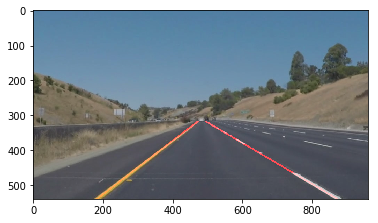

In [5]:
# TODO: Build your Pipeline that will Draw Lane Lines on the test_images,
# Then Save them to the test_images_output Directory.

##########################################################################################
# NMK 2018-03-01: LANE DETECTION PIPELINE
##########################################################################################
def pipeline_detect_lanes(img_in):
    # NMK 2018-03-01: Convert Input Image File to Grayscale.
    img_gray = grayscale(img_in)
    
    # NMK 2018-03-01: Apply Gaussian Blur to Prepare for Canny Edge Detection.
    gaussian_kernel_size = 3
    img_blur = gaussian_blur(img_gray, gaussian_kernel_size)
    
    # NMK 2018-03-01: Perform Canny Edge Detection and Get the Edges.
    canny_threshold_low  =  50
    canny_threshold_high = 150
    img_edges = canny(img_blur, canny_threshold_low, canny_threshold_high)
    
    # NMK 2018-03-01: Region Of Interest (ROI).
    # Get Input Image Shape.
    img_in_shape = img_in.shape # img_in_shape[0] -> No. of Rows,    y Size.
                                # img_in_shape[1] -> No. of Columns, x Size.
                                # img_in_shape[2] -> No. of Color Channels.
    # Specify ROI Vertices. Using % of Size so as to handle Images of Any Size.
    y_top_pcent       = 0.59 # % Of y Size (Image Height) For Top       Vertices.
    x_left_top_pcent  = 0.48 # % Of x Size (Image Length) For Left  Top Vertex.
    x_right_top_pcent = 0.54 # % Of x Size (Image Length) For Right Top Vertex.
    roi_vertices = np.array([[
                              (x_right_top_pcent*img_in_shape[1], y_top_pcent*img_in_shape[0]), # Right Top.
                              (x_left_top_pcent*img_in_shape[1], y_top_pcent*img_in_shape[0]),  # Left  Top.
                              (0,img_in_shape[0]),              # Left Bottom.
                              (img_in_shape[1],img_in_shape[0]) # Right Bottom.
                            ]],
                            dtype=np.int32)
    # Extract ROI of Edges Image.
    img_edges_roi = region_of_interest(img_edges, roi_vertices)
    
    # NMK 2018-03-01: Detect Hough Lines.
    # Define the Hough Transform Parameters.
    h_rho   = 1         # Hough Grid Distance Resolution in Pixels.
    h_theta = np.pi/180 # Hough Grid Angular Resolution in Radians.
    h_threshold    = 32 # Minimum Number of Votes (Intersections in Hough Grid Cells).
    h_min_line_len =  6 # Minimum Number of Pixels Making up a Line.
    h_max_line_gap =  2 # Maximum Gap in Pixels Between Connectable Line Segments.
    # Get Hough Lines.
    img_lines = hough_lines(img_edges_roi,
                            h_rho, h_theta, h_threshold,
                            h_min_line_len, h_max_line_gap)
    
    # NMK 2018-03-01: To Use When Using the Edges Image (1 Color Channel):
    # img_edges_3ch = np.dstack((img_edges, img_edges, img_edges))
    # NMK 2018-03-01: Overlay Detected Lines on Original Input Image.
    img_out = weighted_img(img_in, img_lines, α=0.8, β=1., γ=0.) # NMK 2018-03-01: Change the 1st Param accordingly
                                                                 # To get Output from Different Stages Above for Analysis!
    
    return(img_out)

##########################################################################################
# NMK 2018-03-01:
# For Each Input Test Image File,
# Do the PIPELINE OPERATIONS,
# And then Plot to Verify the Output Image,
# And then Save Output back As File With Suffix "Output" in the Same Directory.
##########################################################################################
for file in files:
    # NMK 2018-03-01: Print Test Image File Name.
    print(file)
    
    # NMK 2018-03-01: Read Input Test Image Files & Call THE PIPELINE!:
    if not("Output." in file): # NMK 2018-03-01: To Avoid opening Output Files.
        # NMK 2018-03-01: Read the Input Test Image File.
        img_input = mpimg.imread("test_images/"+file)
        
        # NMK 2018-03-01:
        # Pass Input Image To pipeline_detect_lanes()
        # and Get the FINAL OUTPUT IMAGE.
        img_result = pipeline_detect_lanes(img_input)
        
        # NMK 2018-03-01: cv2 Expects B,G,R. So Convert R,G,B -> B,G,R.
        r,g,b          = cv2.split(img_result)
        img_result_cv2 = cv2.merge((b,g,r))
        
        # NMK 2018-03-01: Plot to Verify the Output Image.
        #plt.imshow(img_result, cmap='gray') # Use For Grayscale Image.
        plt.imshow(img_result)               # Use For Color Image.
        # NMK 2018-03-01: cv2.imshow() Pop-up Window Crashes! To find out why!
        # cv2.imshow("OUTPUT IMAGE", img_result_cv2)
        
        # NMK 2018-03-01: Save OUTPUT back As FILE With Suffix "Output" in the Same Directory.
        cv2.imwrite("test_images/"+            # Directory Path [Relative To PWD].
                    os.path.splitext(file)[0]+ # Input File Name.
                    "_Output"+                 # Suffix.
                    os.path.splitext(file)[1], # File Extension.
                    img_result_cv2)            # OUTPUT IMAGE.

## Test on Videos

You know what's cooler than Drawing Lanes over Images? Drawing Lanes over Video!

We can Test our Solution on two provided Videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: If you get an Import Error when you Run the next Cell, try changing your Kernel (Select the Kernel Menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the Terminal Prompt. Also, consult the Forums for more Troubleshooting Tips.**

**If you get an Error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe.
You can Download it by calling:
imageio.plugins.ffmpeg.download()
```
**Follow the Instructions in the Error Message and Check out [this Forum Post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more Troubleshooting Tips across Operating Systems.**

In [6]:
# Import Everything Needed to Edit/Save/Watch Video Clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The Output you Return should be a Color Image (3 Channels)
    # for Processing Video below.
    # TODO: Put your Pipeline here,
    # you should Return the Final Output (Image where Lines are Drawn on Lanes).
    
    # NMK 2018-03-01:
    # Pass Input Image To pipeline_detect_lanes()
    # and Get the FINAL OUTPUT IMAGE.
    result = pipeline_detect_lanes(image)
    
    return result

Let's try the One with the Solid White Lane on the Right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To Speed-up the Testing process,
## you may want to try your Pipeline on a Shorter Subclip of the Video.
## To do so, add .subclip(start_second,end_second) to the End of the Line below,
## where start_second and end_second are Integer Values
## representing the Start and End of the Subclip.
## You may also Uncomment the following Line for a Subclip of the First 5 Seconds:
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: This Function expects Color Images!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:10<00:00, 21.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 12.1 s


Play the Video inline, or if you prefer find the Video in your FileSystem (should be in the same Directory) and Play it in your Video Player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() Function

**At this point, if you were successful with making the Pipeline and Tuning Parameters, you probably have the Hough Line Segments drawn onto the Road, but what about identifying the Full Extent of the Lane and marking it clearly as in the Example Video (P1_example.mp4)?  
Think about defining a Line to run the Full Length of the Visible Lane based on the Line Segments you identified with the Hough Transform. As mentioned previously, try to Average and/or Extrapolate the Line Segments you've detected to map out the Full Extent of the Lane Lines. You can see an Example of the Result you're going for in the Video "P1_example.mp4".**

**Go back and Modify your draw_lines() Function accordingly and try Re-running your Pipeline. The New Output should Draw a Single, Solid Line over the Left Lane Line and a Single, Solid Line over the Right Lane Line. The Lines should Start from the Bottom of the Image and Extend out to the Top of the Region Of Interest.**

Now for the One with the Solid Yellow Lane on the Left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To Speed-up the Testing process,
## you may want to try your Pipeline on a Shorter Subclip of the Video.
## To do so, add .subclip(start_second,end_second) to the End of the Line below,
## where start_second and end_second are Integer Values
## representing the Start and End of the Subclip.
## You may also Uncomment the following Line for a Subclip of the First 5 Seconds:
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image) #NOTE: This Function expects Color Images!
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:36<00:00, 18.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 38.2 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your Video Outputs, it's time to make the Report Writeup in a pdf or Markdown File.  
Once you have this Ipython Notebook ready along with the Writeup, it's time to Submit for Review!  
Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the Writeup Template File.

## Optional Challenge

Try your Lane Finding Pipeline on the Video below.  
Does it still work?  
Can you figure out a way to make it more Robust?  
If you're up for the Challenge, Modify your Pipeline so it works with this Video and Submit it along with the rest of your Project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To Speed-up the Testing process,
## you may want to try your Pipeline on a Shorter Subclip of the Video.
## To do so, add .subclip(start_second,end_second) to the End of the Line below,
## where start_second and end_second are Integer Values
## representing the Start and End of the Subclip.
## You may also Uncomment the following Line for a Subclip of the First 5 Seconds:
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image) #NOTE: This Function expects Color Images!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:26<00:00,  9.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 36.3 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))